# Text Classification

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express about
your company’s product on Twitter. In this chapter, we’ll tackle this task using a variant
of BERT called DistilBERT. The main advantage of this model is that it achieves
comparable performance to BERT, while being significantly smaller and more efficient.
This enables us to train a classifier in a few minutes.

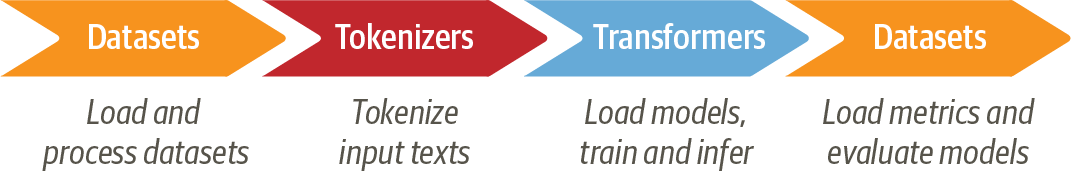

Figure 2-2. A typical pipeline for training transformer models with the Hugging Face Datasets, Tokenizers, and Transformers libraries

## Dataset

dataset contains
six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet,
our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

In [1]:
import datasets
print(datasets.__version__)

/home/praffulvyas/nlp_with_transformers/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.4.1


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 336594.49 examples/s]


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [11]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


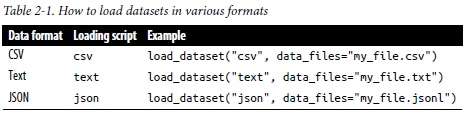

#### load url

```
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

# peek at first row of train.txt
!head -n 1 train.txt

# load the file
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                                names=["text", "label"])

# or mention URL itself
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                                names=["text", "labels"])
```

### From Datasets to DataFrames

In [12]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


labels are represented as integers, use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Look at the Class Distribution

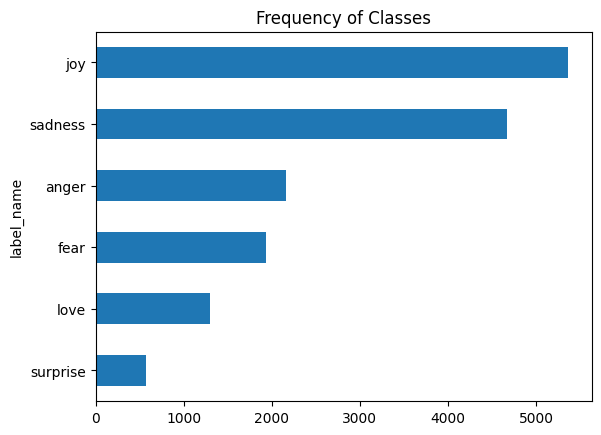

In [15]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness
classes appear frequently, whereas love and surprise are about 5–10 times rarer.
There are several ways to deal with imbalanced data, including:

- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

- Imbalanced-learn library

### How Long are your Tweets?

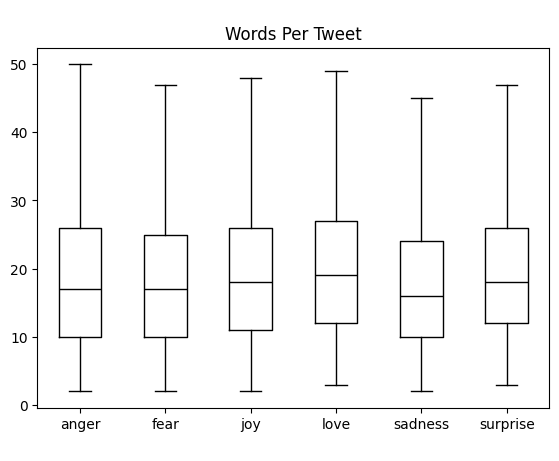

In [17]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
            showfliers=False, color="black")
plt.suptitle(" ")
plt.xlabel(" ")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

Let’s now figure out how we can convert these raw texts into a format suitable for
Transformers! While we’re at it, let’s also reset the output format of our dataset
since we don’t need the DataFrame format anymore:

In [18]:
emotions.reset_format()

## From Text to Tokens

### Character Tokenization

In [19]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [20]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


We can now use token2idx to transform the tokenized text to a list of integers:

In [21]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


last step is to convert input_ids to a 2D tensor of one-hot vectors

In [22]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


We won't be using this, Not good for neural networks. In pandas, one-hot encoding can be implemented with get_dummies() function as follows:

In [25]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


We can create the one-hot encodings in PyTorch by converting input_ids to a tensor and applying the one_hot() function as follows:

In [27]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions,
since our vocabulary consists of 20 unique characters.

WARN: It’s important to always set num_classes in the one_hot() function
because otherwise the one-hot vectors may end up being shorter
than the length of the vocabulary (and need to be padded with
zeros manually). In TensorFlow, the equivalent function is
tf.one_hot(), where the depth argument plays the role of
num_classes.

In [28]:
# first vector
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any
structure in the text and treats the whole string as a stream of characters. Although
this helps deal with misspellings and rare words, the main drawback is that linguistic
structures such as words need to be learned from the data. This requires significant
compute, memory, and data. For this reason, character tokenization is rarely used in
practice. Instead, some structure of the text is preserved during the tokenization step.
Word tokenization is a straightforward approach to achieve this, so let’s take a look at
how it works.

### Word Tokenization

In [29]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


NOTE: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g. "great", "greater", "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character
and word tokenization. On the one hand, we want to split rare words into smaller
units to allow the model to deal with complex words and misspellings. On the other
hand, we want to keep frequent words as unique entities so that we can keep the
length of our inputs to a manageable size. The main distinguishing feature of
subword tokenization (as well as word tokenization) is that it is learned from the pretraining
corpus using a mix of statistical rules and algorithms.

In [30]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically
retrieve the model’s configuration, pretrained weights, or vocabulary from
the name of the checkpoint. This allows you to quickly switch between models, but if
you wish to load the specific class manually you can do so as well. For example, we
could have loaded the DistilBERT tokenizer as follows:

In [31]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

lets see how tokenizer works:

In [32]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can see that the words have been mapped to unique integers in the input_ids field. attention_mask will be discussed later. Now that we have the input_ids field, we can convert them back into tokens using tokenizer's convert_ids_to_tokens() method:

In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.
Finally, we can see that “tokenizing” and “NLP” have been split into two tokens,
which makes sense since they are not common words. The ## prefix in ##izing and
##p means that the preceding string is not whitespace; any token with this prefix
should be merged with the previous token when you convert the tokens back to a
string. 

The AutoTokenizer class has a convert_tokens_to_string() method for
doing just that, so let’s apply it to our tokens:

In [34]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


AutoTokenizer has several attributes, we can inspect the vocabulary size:

In [35]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [36]:
tokenizer.model_max_length

512

another attribute - name of the fields that the model expects in its forward_pass

In [37]:
tokenizer.model_input_names

['input_ids', 'attention_mask']